<a href="https://colab.research.google.com/github/CopurOnur/Emotion_Recognition/blob/main/FER_Emotion_Recognition_with_LIME_interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# Facial Emotion Recognition with FER2013 dataset

*In* this project, we will develop a CNN model for detecting 7 basic emotions which are, Angry, Disgust, Fear, Happy, Sad, Surprise and  Neutral. For this task, we choose the [FER2013](https://www.kaggle.com/deadskull7/fer2013) dataset. This datset contains 35887 48x48 gray scale face images each representing one of the emotions listed above. The model is taken from this [github](https://github.com/elzawie/FER2013) repository. 

## Fetch Data

The code chunk bellow access my shared google dirve folder and fetch dataset and pre-trained weights. For authentications you need to sign in with your google account but dont worry, it is not mounting to your drive. 

In [ ]:
from google.colab import auth

auth.authenticate_user()  # must authenticate


'''list all ids of files directly under folder folder_id'''

def folder_list(folder_id):

  from googleapiclient.discovery import build

  gdrive = build('drive', 'v3').files()

  res = gdrive.list(q="'%s' in parents" % folder_id).execute()

  return [f['id'] for f in res['files']]



'''download all files from a gdrive folder to current directory'''

def folder_download(folder_id):

  for fid in folder_list(folder_id):

    !gdown -q --id $fid

link='https://drive.google.com/drive/folders/1o8p8svb3LnwbMnEbeI6P16sGCnn1G7Hr?usp=sharing'


folder_id="1o8p8svb3LnwbMnEbeI6P16sGCnn1G7Hr"

folder_download(folder_id)

Permission denied: https://drive.google.com/uc?id=10hediu-oU1Cqqj1GJgTJhKonIPIW7R6J
Maybe you need to change permission over 'Anyone with the link'?
Permission denied: https://drive.google.com/uc?id=1bdexnSkZxLeaq1_Rc2_8_wstNenpA6aL
Maybe you need to change permission over 'Anyone with the link'?


# Imports

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import  RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
%matplotlib inline

# Checking if GPU is available
tf.test.gpu_device_name()
tf.test.is_gpu_available(cuda_only=False)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

# Some helper functions

In [ ]:

# Function for displaying 15 random images
def show_random(imgs, emotion_nms_org = None, emotion_nms_pred = None, random = True, indices = None):
 
    if random == True:
        indices = np.random.randint(0, len(imgs), size = 15)
    else:
        indices = np.random.choice(list(indices), size = 15, replace = False)
    plt.figure(figsize=(20, 14)) 
    for index, number in enumerate(indices):
        plt.subplot(3,5, index + 1)
        if (isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]))           
        elif (isinstance(emotion_nms_org, type(None)) & ~isinstance(emotion_nms_pred, type(None))):
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        elif (~isinstance(emotion_nms_org, type(None)) & isinstance(emotion_nms_pred, type(None))):
             plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]])           
        else:
            plt.title('Image: ' + str(indices[index]) + '\n' + 'Original emotion: ' + emotion_nms_org[indices[index]] + 
                      '\n' + 'Predicted emotion:' + emotion_nms_pred[indices[index]])
        show_image = imgs[number].reshape(48,48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')
        
# Function for creating zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot


# Data pre-processing
we load the data from csv file and each image is represented as a 2304 sized array. In the code chunk bellow, we first normalize each image by subtracting mean pixel value and dividing to pixel standard devation. Then each image is reshaped as 48x48x1 to feed into the CNN model. Also the emotion labels are one hot coded and the train validation, test split is made.

In [ ]:
data = pd.read_csv("/content/fer2013.csv")

emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
data['emotion_name'] = data['emotion'].map(emotions_names)

pixels_values = data.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values, dtype=int)
images = pixels_values.values
images = images.astype(np.float)

test_idx_start = 32298
images_test = images[test_idx_start:]

# Standarizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)


image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]




labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

### Lets see some samples from the data


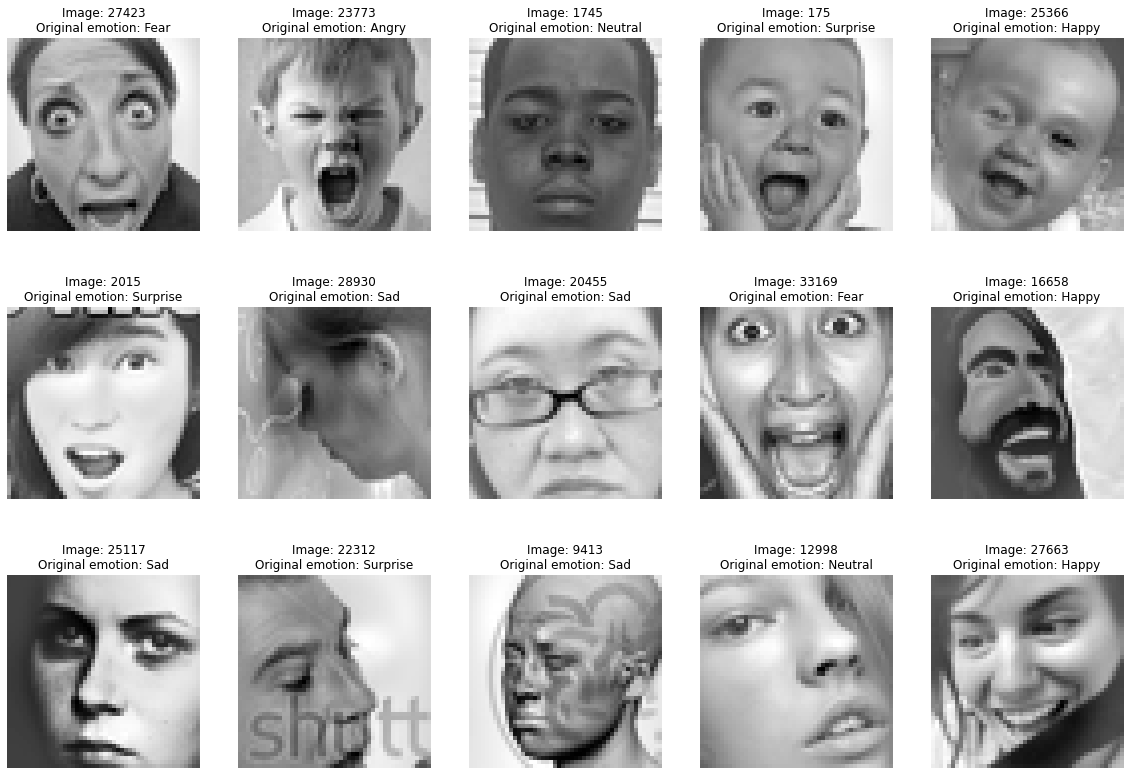

In [ ]:
show_random(images, emotion_nms_org= data['emotion_name'])

In [ ]:
images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

# The MODEL

The CNN model we use is a simple CNN architecture composed of 4 blocks each with 2 convolutional layers, a batch normalization layer, max pooling layer and finally drop out. After the CNN blocks, a fully connected layer is used for 7 class classification. In total, there are 3,332,679 trainable and 1,024 non trainable parameters. The details are visible in the model summary bellow.

In [ ]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 64)        3

For model robustness, data augmentation is critical in deep learning. In the code chunk bellow, you can see that each image is rotated ramdomly 40 degrees, the height and width is shifted randomly %20 percent, zoom in and zoom at randomly 5% and finally images are randomly horizontally fliped. After applying this augmentations to the training images, the images are passed to the modelwith batches of 32. The model is trained for 300 epochs and the best model is saved.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]

datagen.fit(X_train)


# Saving model each time it achieves lower loss on the validation set
filepath='/content/Model.{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./logs')


history = model.fit_generator(datagen.flow(X_train, y_train,
                    batch_size=32),
                    epochs=300,
                    validation_data=(X_val, y_val),
                    steps_per_epoch=X_train.shape[0]/32,
                    callbacks=[checkpointer,tensorboard]
                             )


pd.DataFrame(history.history).to_csv("history.csv")

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
908/908 [==============================] - 35s 18ms/step - loss: 2.6086 - accuracy: 0.2087 - val_loss: 1.9359 - val_accuracy: 0.2415

Epoch 00001: val_loss improved from inf to 1.93593, saving model to /content/Model.01-0.2415.hdf5
Epoch 2/300
908/908 [==============================] - 15s 16ms/step - loss: 1.8165 - accuracy: 0.2449 - val_loss: 2.1530 - val_accuracy: 0.2483

Epoch 00002: val_loss did not improve from 1.93593
Epoch 3/300
908/908 [==============================] - 15s 16ms/step - loss: 1.8048 - accuracy: 0.2482 - val_loss: 1.9707 - val_accuracy: 0.2427

Epoch 00003: val_loss did not improve from 1.93593
Epoch 4/300
908/908 [==============================] - 15s 16ms/step - loss: 1.7954 - accuracy: 0.2549 - val_loss: 2.1956 - val_accuracy: 0.2653

Epoch 00004: val_loss did not improve from 1.93593
Epoch 5/300
908/908 [==============================] - 15s 16ms/step - loss: 1.7853 - accuracy: 0.2630 - val_loss: 2.1860 - val_accuracy: 0.2675

Epoch 00005: val_lo

# Model Evaluation
The best accuracy reached by this model is 0.676 on the test set. Currently, the state of the art accuracy for this dataset is 0.768 achived by Ensemble [ResMaskingNet with 6 other CNNs](https://github.com/justinshenk/fer). In the graphs bellow, you can also see the train validation accuracy an loss graphs. After 170 epochs the model starts to overfit as we can see from the slight downward trend in accuracy graph and also from the sudden peaks of the loss graph.  Finally in the confusion matrix you can see that the most accurately recognized emotion is happiness and the less accurate is Disgust. There some possible reasons for that. The first one is the imbalanced number of samples of different labels. As seen there are only 55 samples for the disgust label but on the otherhand there are 879 samples for the happiness label. The second reason can the correlation with other labels. Happiness is pretty different from other labels and it is distinctive with smile. On the other hand, Disgust and Anger can have very simmilar facial expressions and it is harder to distinguish these two emotions. This can be also seen from the confusion matrix as more angry predictions are made than disgust for the images with disgust ground truth. 

In [ ]:
model2 = load_model('/content/Best_model_6759OffTest.hdf5')

scores = model2.evaluate(np.array(X_test), np.array(y_test), batch_size=1024)
print("Loss: " + str(scores[0]))
print("Accuracy: " + str(scores[1]))


4/4 [==============================] - 2s 219ms/step - loss: 1.1458 - accuracy: 0.6760
Loss: 1.1458004713058472
Accuracy: 0.675954282283783


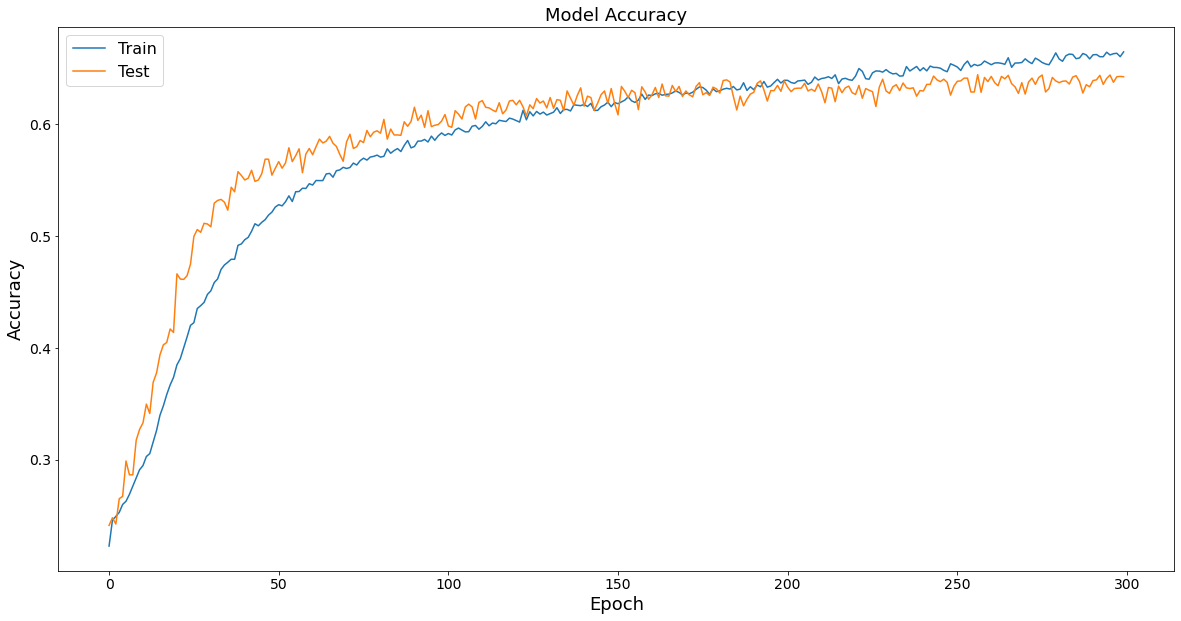

In [ ]:
history = pd.read_csv('history.csv', usecols = ['accuracy','loss','val_accuracy','val_loss'])
def plot_accuracy(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['accuracy'])
    plt.plot(data['val_accuracy'])
    plt.title('Model Accuracy', fontsize = 18)
    plt.ylabel('Accuracy', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_accuracy(history)


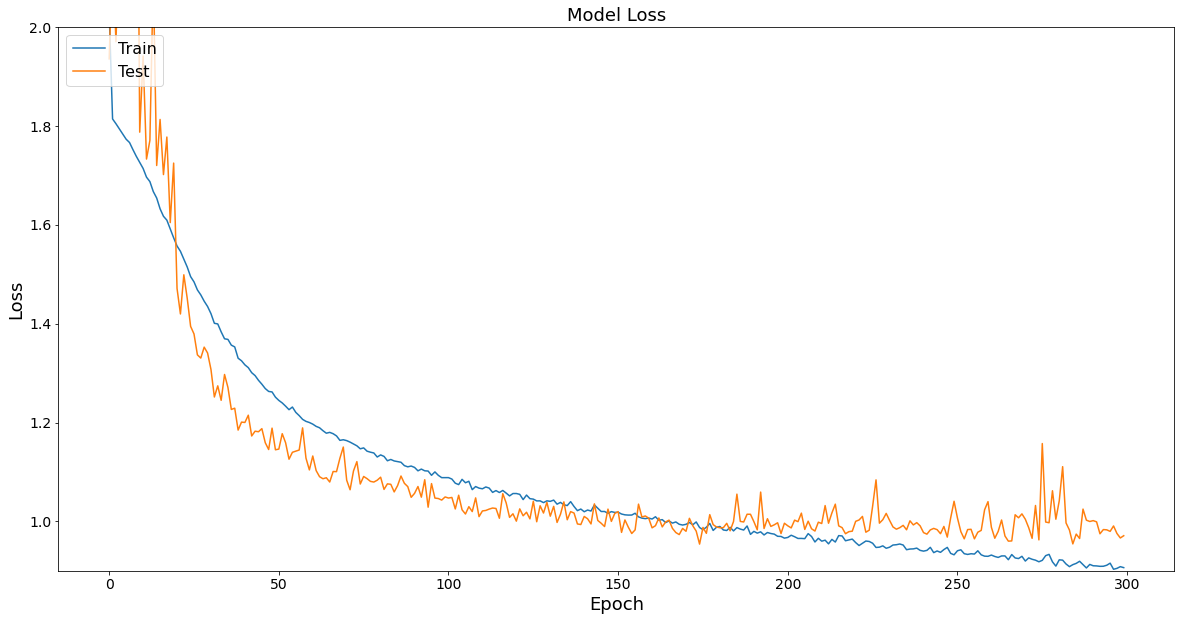

In [ ]:
def plot_loss(data, size = (20,10)):
    plt.figure(figsize=size) 
    plt.plot(data['loss'])
    plt.plot(data['val_loss'])
    plt.title('Model Loss', fontsize = 18)
    plt.ylabel('Loss', fontsize = 18)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylim(0.9,2)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 16)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()
    
plot_loss(history)

In [ ]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results

In [ ]:
def create_confmat(true_labels, predicted_labels, columns, colour = 'Oranges', size = (20,14)):
    
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

In [ ]:
correct, results_df = predict_classes(model2, X_test, y_test, emotions_names, batch_size = 1024)
results_df['Original_label'] = data['emotion'][32298:].values
results_df['True_emotion'] = results_df['Original_label'].map(emotions_names)

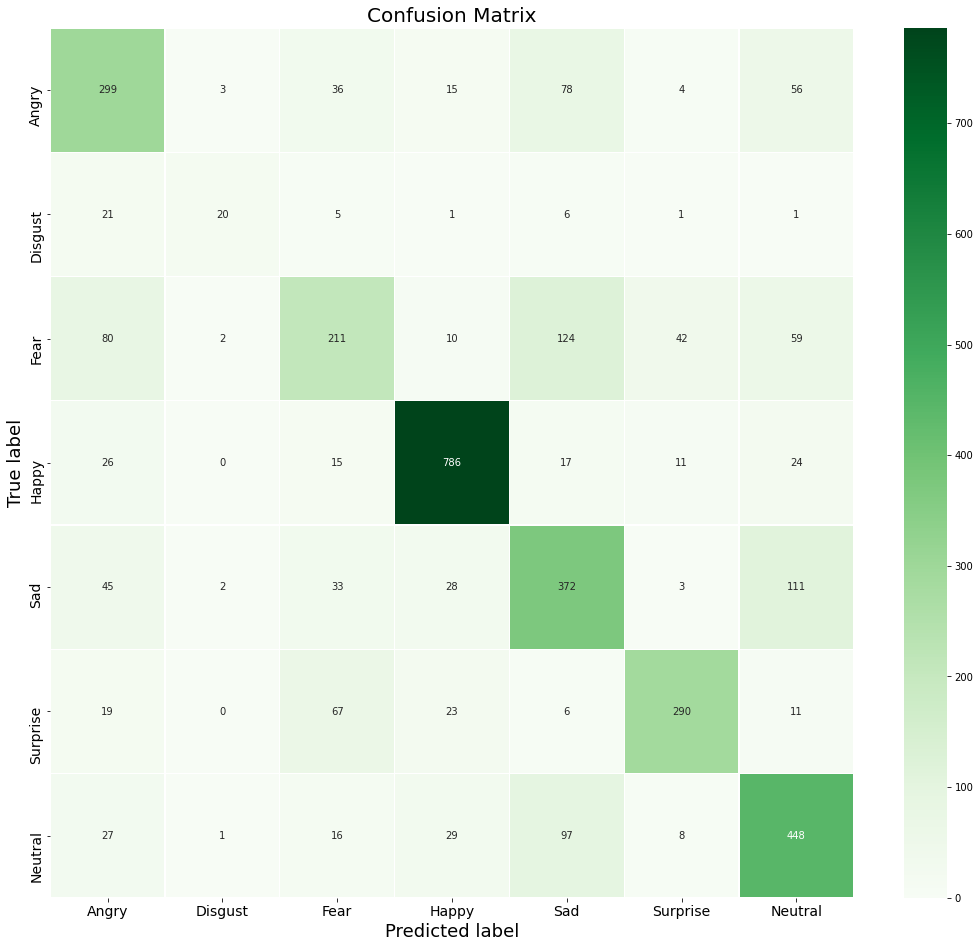

In [ ]:
# Displaying confusion matrix
create_confmat(results_df['Original_label'], results_df['Predicted_label'], ['Angry','Disgust','Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'], colour = 'Greens')

# Some Fun (My Emotions)

Bellow, you can see the performance of the model for predicting my emotions :).
I used haarcascade for cropping the face from my selfie, rescaled to 48x48 and then converted to gray scale to pass the model. 

In [ ]:
import os
import cv2



emotion_dict = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}

def my_emotions(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)

  for (x, y, w, h) in faces:
      cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
      roi_gray = gray[y:y + h, x:x + w]
      cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
      cv2.normalize(cropped_img, cropped_img, alpha=0, beta=1, norm_type=cv2.NORM_L2, dtype=cv2.CV_32F)

  prediction = model2.predict(cropped_img)
  prediction

  from google.colab.patches import cv2_imshow
  image = cv2.resize(image, (300, 400)) 
  cv2.putText(image, emotion_dict[int(np.argmax(prediction))], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 1, cv2.LINE_AA)
  
  cv2_imshow(image)

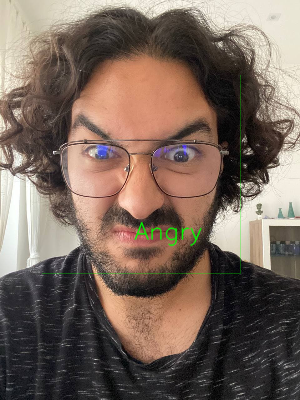

In [ ]:
image = cv2.imread("/content/angry.jpg")
my_emotions(image)

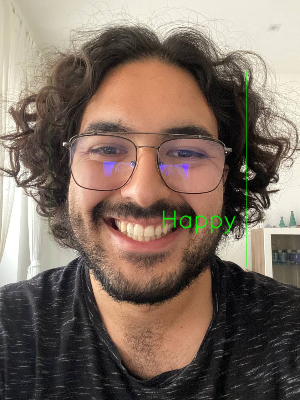

In [ ]:
image = cv2.imread("/content/happy.jpg")
my_emotions(image)

In this section, we will use lime for interpreting the predictions of my model. Bellow you can see a correctly classified sample from each emotion label. There are 4 figures presented for each label, the first figure shows the original image, the second figure shows the super pixels contributing poisitively to the prediction in the rgb image format. In this, some samples looks dark because of converting from gray scale to rgb. The third figure in each sample shows the same pixels but this time the boundry of theese positively contributing pixels are marked on the gray scale image. Finally, the last figure shows the boundry of the pixels negatively contributing to the prediction of the label.

In [ ]:
!pip install lime

In [ ]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)

In [ ]:
def exp_mask(x,y):
  image_inter = x
  label_inter = y
  explanation = explainer.explain_instance(image_inter.astype('double'), 
                                         classifier_fn = model2.predict_proba, 
                                         top_labels=7, hide_color=0, num_samples=10000, segmentation_fn=segmenter)
  
  temp, mask = explanation.get_image_and_mask(np.where(label_inter==1)[0][0], positive_only=True, num_features=10, hide_rest=False)
  backtorgb = cv2.cvtColor(temp.astype('float32'),cv2.COLOR_GRAY2RGB)
  fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize = (15, 10))
  ax1.imshow(image_inter.reshape(48,48),cmap="gray")
  ax2.imshow(label2rgb(mask,backtorgb, bg_label = 0), interpolation = 'nearest')
  ax2.set_title('Positive Regions for {}'.format(emotion_dict[explanation.top_labels[0]]))
  temp, mask = explanation.get_image_and_mask(np.where(label_inter==1)[0][0], positive_only=True, num_features=10, hide_rest=True)
  ax3.imshow(mark_boundaries(temp.reshape(48,48)/2 +0.5, mask),cmap='gray')
  ax3.set_title('pixels positively contribute to prediction of {}'.format(emotion_dict[explanation.top_labels[0]]))
  temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = False, negative_only=True, num_features=5, hide_rest=False)
  ax4.imshow(mark_boundaries(temp.reshape(48,48) / 2 + 0.5, mask))
  ax4.set_title('pixels negatively contribute to prediction of {}'.format(emotion_dict[explanation.top_labels[0]]))



# Correct predictions

The first sample is the prediction of the happiness label. As seen from figures 2 and 3, the mouth region pixels are positively contributing to the prediction of happiness. This is makes a lot of intuitive sense because happiness is mostly recognizable with a smile and this is also what the model is looking for. On the other hand the pixels negatively contributing to the happiness prediction is shown in the last figure. These 3 regions are not giving any intuitive insights.

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/skimage/color/colorlabel.py:111: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


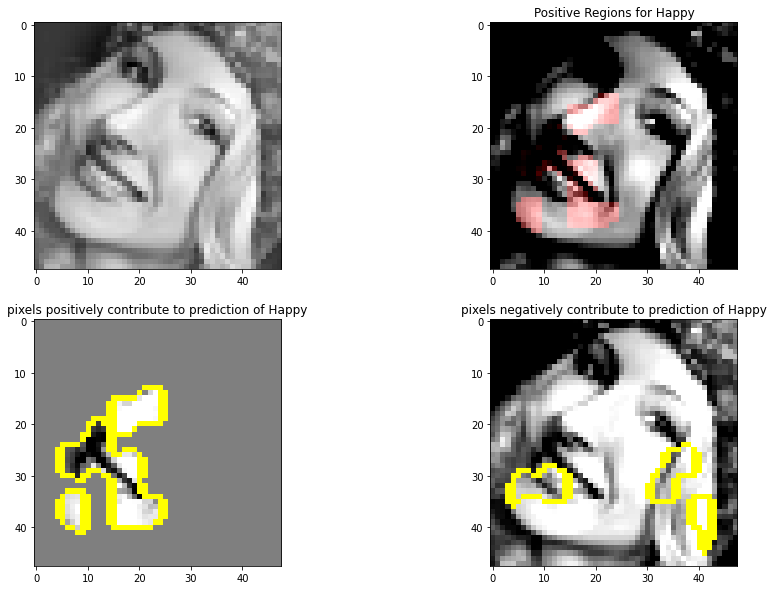

In [ ]:
exp_mask(X_test[806],y_test[806]) # Happy

The second sample is labeled as sad. In the figures 2 and 3 we saw that the pixels contributing to sadness prediction is concentrated around eyes and eye brows, which makes intuitive sense and the pixels negatively contributing to sadness is concentrated around mouth. The reason for this can be the model relates the shape of the mouth with a smile therefore with happiness. This is actually reasonable because if you just see the mouth area, this sample can be classified as happy.  

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/skimage/color/colorlabel.py:111: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


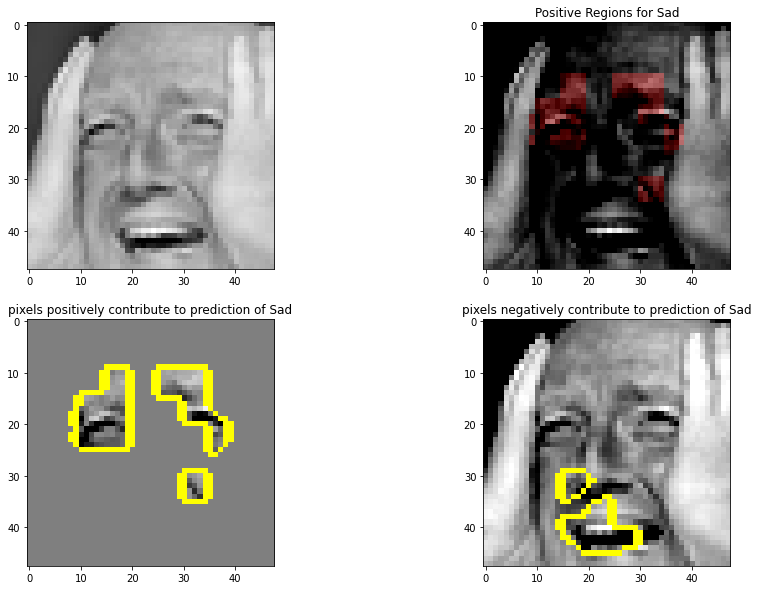

In [ ]:
exp_mask(X_test[2684],y_test[2684]) # Sad

The third sample is labeled as surprised. Here we see that the pixels around eyes and mouth contributes positively to this prediction since open eyes and mouth indicates surprise intuitively. On the other hand it is hard to describe intuively why the areas in figure 4 contributes negatively to the prediction.

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/skimage/color/colorlabel.py:111: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


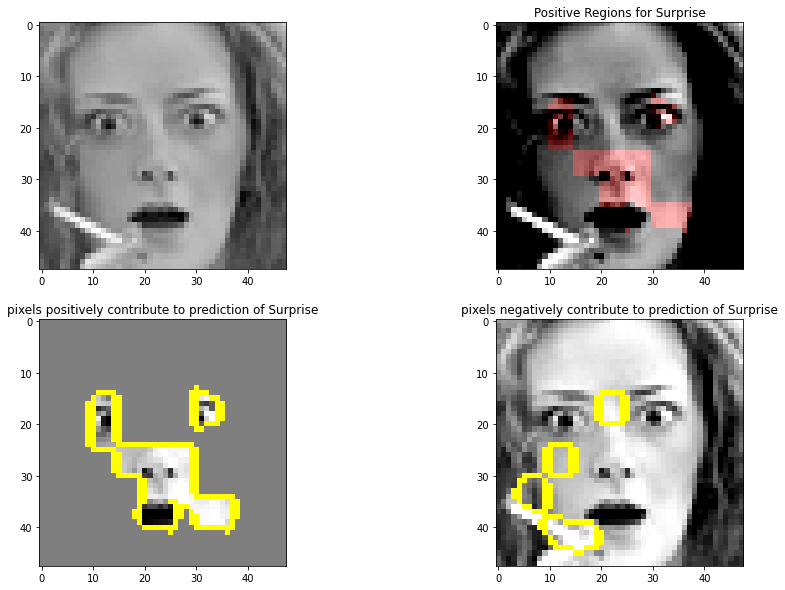

In [ ]:
exp_mask(X_test[2102],y_test[2102]) # surprised

The fourth sample is labeled as neutral. simmilar to surprise, this time flat eyes and mouth indicates neutral.

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/skimage/color/colorlabel.py:111: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


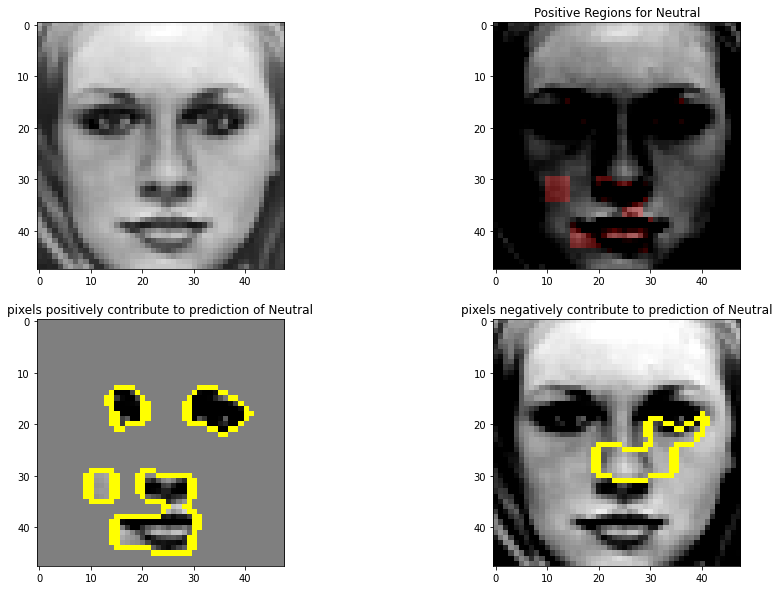

In [ ]:
exp_mask(X_test[310],y_test[310])

The fifth sample is labeled as angry. As seen bellow the pixels contributing positively to this prediction are concentrated around eye and eye brow area which are the features obviously indicating anger. 

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/skimage/color/colorlabel.py:111: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


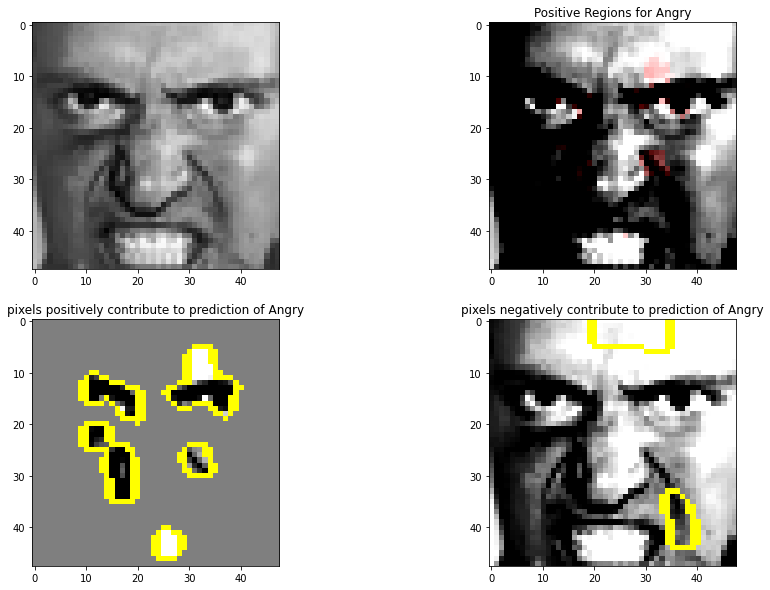

In [ ]:
exp_mask(X_test[2452],y_test[2452]) # Angry

The sixth sample is labeled as Fear. Here again we see a pretty intuitive predciton as the pixels around eyes and eye brows contribute the fear prediction. 

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/skimage/color/colorlabel.py:111: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


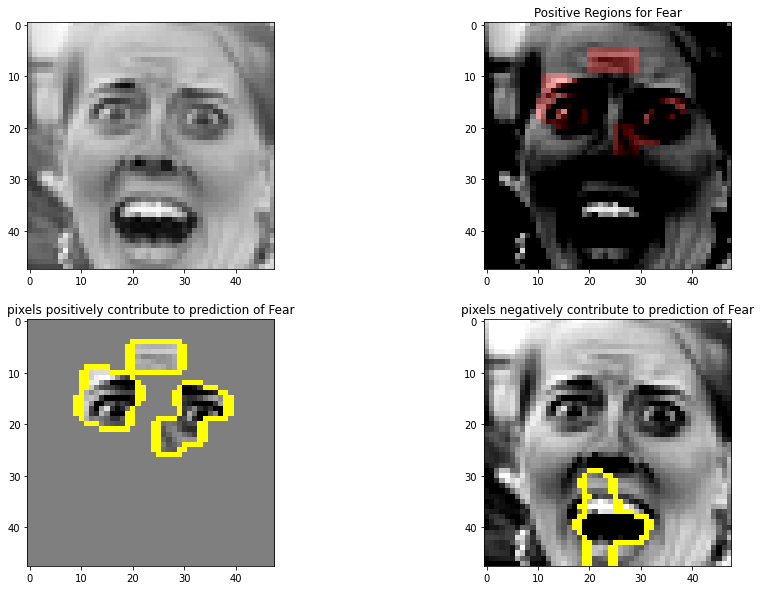

In [ ]:
exp_mask(X_test[2631],y_test[2631]) # Fear

The Final sample is labeled as disgust. Different from other samples Here we saw rhe pixels around nose also plays a role in attion to eyes and eye brows. The reason for that can be the disgust emotion can be more explanied with wrinkles around nose.

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


/usr/local/lib/python3.7/dist-packages/skimage/color/colorlabel.py:111: UserWarning: Negative intensities in `image` are not supported
  bg_color, image_alpha)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


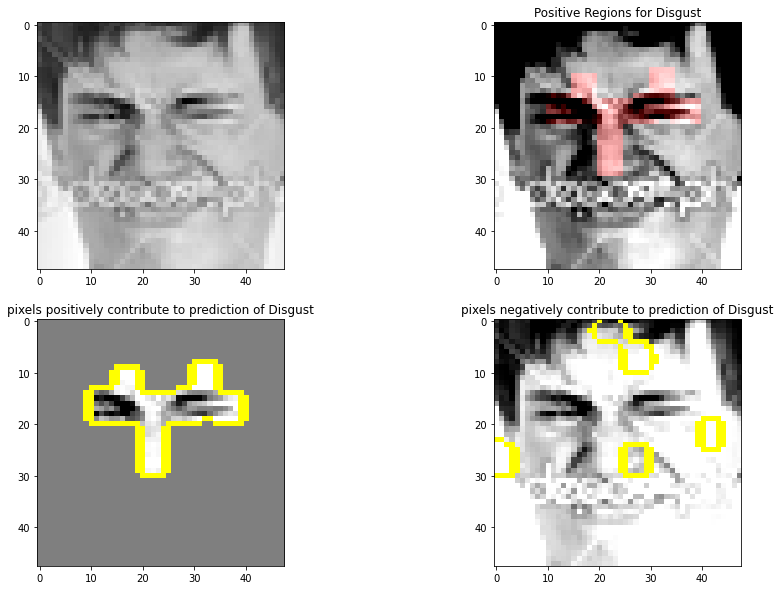

In [ ]:
exp_mask(X_test[227],y_test[227]) # Disgust

# Conclusion

As we saw from the samples above, we can say that our model is able to capture the features indicating different facial emotions. In the all samples above, the super pixels contributing to the predictions makes intuitive sense. Also in the most of the samples, super pixels contributing negativel can be explained intuitively. In the end we can say that this model is suitable for facial emotion recogniton task. The accuracy is not so high but the interpretabilty analysis shows that the model is able to learn the underground relations between emotions and facial expressions up to some accuracy. 